# Fitting lightcurves with Gaussian Processes: SN 2008ax example

This jupyter notebook provides extra detail regarding the data anlysis code used to fit all the SNe lightcurves in the paper. The other jupyter notebooks will have repeated code and the odd comment, you should start here.


## 1. Set up
The python imports are pretty straight forward, you should already have most of the necessary library - you might need to download `GPy` and `sklearn` as you won't have them installed if you don't typically work with Machine Learning tools.

The clean sample of type IIb SN Lightcurves is in `../Data/IIb_clean_sample.dat` and the rise times are in `../Data/trise_tmax_IIb.dat`. The type II lightcurves have analogously named files. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle

import GPy
from sklearn import gaussian_process as sklgp

## Put your prefered mpl style here isntead of mine
plt.style.use('hfs')

In [2]:
data = pd.read_csv('../Data/IIb_clean_sample.dat', index_col=0)
trise_tmax=pd.read_csv('../Data/trise_tmax_IIb.dat', index_col=0)

### 1.1 Set up the table in which we'll record all the results for the IIbs

In [3]:
trise_tmax = pd.DataFrame( columns=['event', 'texp', 'trise', 'e_trise', 'dm4030', 'e_dm4030'])
trise_tmax['event']=data.event.unique()
trise_tmax = trise_tmax.set_index('event')
trise_tmax.to_csv('trise_tmax_IIb.dat')


results = pd.DataFrame( columns=['event', 'texp', 'trise', 'dm1', 'dm2', 'dm4030'])
results['event']=data.event.unique()
results = results.set_index('event')
results.to_csv('params_best_GP_IIb.dat')

results_skl = pd.DataFrame(columns=['event', 'texp', 'trise', 'dm1', 'dm2', 'dm4030'])
results_skl['event']=data.event.unique()
results_skl = results_skl.set_index('event')
results_skl.to_csv('params_best_GP_IIb_SKL.dat')

### 1.2 Now select only the data of the SN we care about

In [4]:
# let's select only the data of SN2008ax. we drop the "event" column because we know which SN we're working with
sn='SN2008ax'
data=data[data.event==sn].drop('event',axis=1) 

The data contains 6 columns: 
* `MJD` (from the open supernova catalogue)
* `V` (apparent; from the open supernova catalogue)
* `source` (the source of the photometric data, alos from open supernova catalogue)
* `texp` (explosion date)
* `texp_source` ("source" of the explosion date: OBS. is constrained from previous non detections and SNID is SNID)
* `Verr` (the err on the photometry; from the open supernova catalogue)

In [5]:
data

,MJD,V,source,texp,texp_source,Verr
0,54531.08,16.290,"2008MNRAS.389..955P,Sternberg Astronomical Ins...",54528.3,OBS.,0.067
1,54532.01,15.920,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.030
2,54532.05,15.952,"2008MNRAS.389..955P,Sternberg Astronomical Ins...",54528.3,OBS.,0.042
3,54532.91,15.562,"2008MNRAS.389..955P,Sternberg Astronomical Ins...",54528.3,OBS.,0.031
4,54533.03,15.528,"2008MNRAS.389..955P,Sternberg Astronomical Ins...",54528.3,OBS.,0.014
...,...,...,...,...,...,...
75,54673.84,17.010,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.060
76,54674.82,17.010,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.040
77,54676.82,17.190,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.050
78,54678.82,17.310,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.070


In [6]:
data

,MJD,V,source,texp,texp_source,Verr
0,54531.08,16.290,"2008MNRAS.389..955P,Sternberg Astronomical Ins...",54528.3,OBS.,0.067
1,54532.01,15.920,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.030
2,54532.05,15.952,"2008MNRAS.389..955P,Sternberg Astronomical Ins...",54528.3,OBS.,0.042
3,54532.91,15.562,"2008MNRAS.389..955P,Sternberg Astronomical Ins...",54528.3,OBS.,0.031
4,54533.03,15.528,"2008MNRAS.389..955P,Sternberg Astronomical Ins...",54528.3,OBS.,0.014
...,...,...,...,...,...,...
75,54673.84,17.010,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.060
76,54674.82,17.010,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.040
77,54676.82,17.190,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.050
78,54678.82,17.310,"2009PZ.....29....2T,Sternberg Astronomical Ins...",54528.3,OBS.,0.070


## 2. Fitting

### 2.1 Setting up our data into the right format
The first thing we need to do is scale the time axis from MJD to days since explosions. In general with any ML tool you don't want your axes to be on the scale of hundreds or thousands - it messes with the numerical solvers and can make your life harder or your results terrible. 

In [7]:
t_norm = data.MJD.values - data.texp.iloc[0]
t_exp = 0

Then we set up the `X` and `y` arrays (time and V) - I use this notation because it is very commonly used in standard ML code samples (e.g. in the `sklearn`) tutorials: X is the data and y the "labels" (although here obviously we're doing regression not classification). 

These arrays need to have a very specific shape that is required by the linear algebra magic that happens under the hood. We'll see later that the shape of these arrays can be different for different libraries. 

In [8]:
y=np.atleast_2d(data.V).T
X=np.atleast_2d(t_norm).T

y.shape

(80, 1)

In [9]:
# we also store our error bars for the noise kernels
err = data.Verr.values

### 2.2 Setting up the Kernel

We need to define a `length_scale` and a `variance`. These are only starting points and the python library will then iteratively optimise those values to get the best GP model. Our starting point for the length scale is the mean date after explosion and the variance is the variance of that value. It's not particularly meaningful in terms of supernova physics but in terms of GP as a starting point we're saying that we expect our curve to see some significant variations within the extent of the X (time) axis we gave it. Honestly you can play with these values and put something non-sensical like 1000 days and you'll see it still converges with GPy. 

We set up four kinds of kernels: 
* **RBF** 
* **Mattern 3/2**
* **White Noise**
* **Bias** 

In [10]:
length_scale=np.mean(t_norm) 
variance=np.sqrt(np.std(t_norm))
                 
rbf = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=length_scale)

matern = GPy.kern.Matern32(input_dim=1)

noise = GPy.kern.White(1, GPy.util.linalg.tdot(err)) 

bias = GPy.kern.Bias(1, GPy.util.linalg.tdot(err))

### 2.3 Fitting a with simple Kernel
First let's see what happenes with a simple RBF kernel. 
We need to specific how many times `n` the numerical optimizer will restart - 100 is plenty. We use the GPRegression class in GPy to create a model object `m`, then we optimise.

It should take a few minutes or so but if it takes too long there could be a bigger problem with the fit - we need to plot it to make sure:

In [11]:
kernel = rbf
n=100

# instanciate model oject
m_rbf = GPy.models.GPRegression(X,y,kernel) 
# solve
__ = m_rbf.optimize () 
__ = m_rbf.optimize_restarts (num_restarts = n , parallel = True, verbose=False)

(20.0, 12.0)

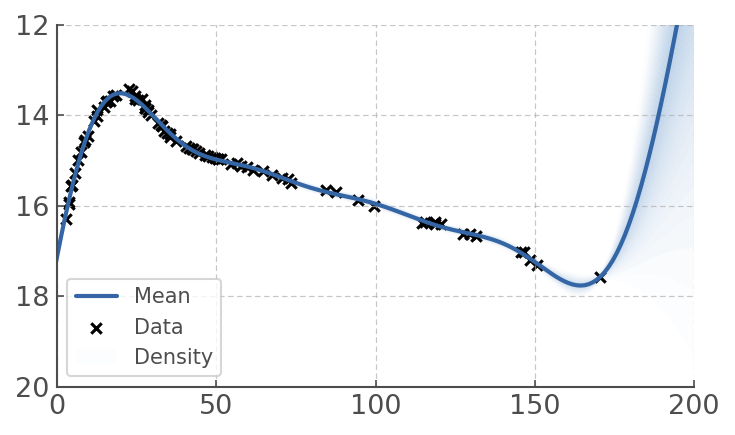

In [12]:
# Now we can plot the restuls
m_rbf.plot(plot_density=True)
plt.gca().invert_yaxis()
plt.xlim([0,200])
plt.ylim([20, 12])

In [13]:
m_rbf

GP_regression.,value,constraints,priors
rbf.variance,163.93473058640555,+ve,
rbf.lengthscale,32.39628918223253,+ve,
Gaussian_noise.variance,0.002947945034983804,+ve,


### 2.4 Fitting a with mixed Kernel
Let's see what happens when we put kernels together

In [14]:
kernel = rbf + noise
m_rbf_noise = GPy.models.GPRegression(X,y,kernel) 
__ = m_rbf_noise.optimize () 
__ = m_rbf_noise.optimize_restarts (num_restarts = n , parallel = True, verbose=False)

(20.0, 12.0)

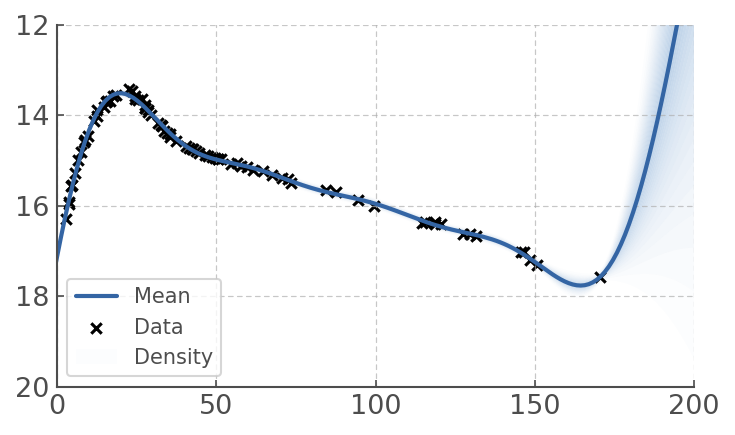

In [15]:
m_rbf_noise.plot(plot_density=True)
plt.gca().invert_yaxis()
plt.xlim([0,200])
plt.ylim([20, 12])

In [16]:
m_rbf_noise

GP_regression.,value,constraints,priors
sum.rbf.variance,163.93491064967372,+ve,
sum.rbf.lengthscale,32.39628110761829,+ve,
sum.white.variance,6.4734200039288855e-28,+ve,
Gaussian_noise.variance,0.0029479475607822624,+ve,


Sometimes adding kernels together will nothing substancial - but in other examples it does!

### 2.5 Matern Vs RBF
The biggest differences are likely to occur in chosing RBF or Matern, as these are the kernels fitting the data and not the noise. As we can see below the Matern kernel has a tendence to overfit the data as much (even a bit more) than the RBF kernel for this particular dataset. In some cases one choice will be obvious over the other - soemtimes not. On the whole, as described in the paper, these kernels are not great to fit SNe because they are **stationary**: they expect large deviations in the data to occur on the same timescale throughout. But we know that is not the case for SNe, which evolve faster earlier on and slower later on. 

In [17]:
kernel = matern
m_matern = GPy.models.GPRegression(X,y,kernel) 
__ = m_matern.optimize () 
__ = m_matern.optimize_restarts (num_restarts = n , parallel = True, verbose=False)

 /home/fste075/.local/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:overflow encountered in multiply
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:484: RuntimeWarning:invalid value encountered in multiply
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:487: RuntimeWarning:overflow encountered in multiply
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:487: RuntimeWarning:invalid value encountered in multiply
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/fste075/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:4

(20.0, 12.0)

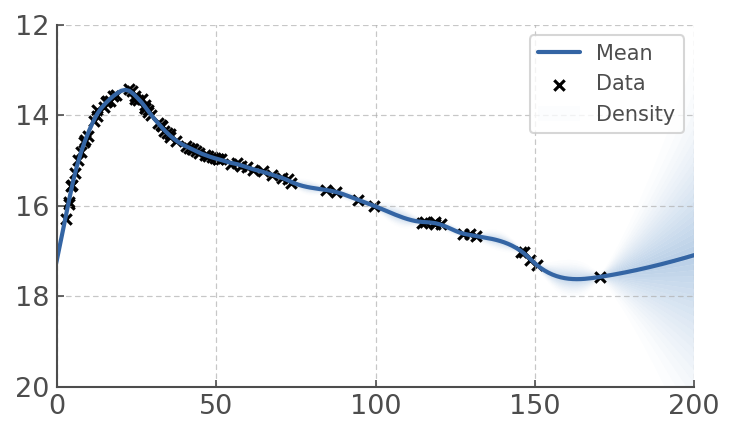

In [18]:
m_matern.plot(plot_density=True)
plt.gca().invert_yaxis()
plt.xlim([0,200])
plt.ylim([20, 12])

In [19]:
m_matern

GP_regression.,value,constraints,priors
Mat32.variance,759.1719549739572,+ve,
Mat32.lengthscale,319.8539234452007,+ve,
Gaussian_noise.variance,0.0012847909803584442,+ve,


## 3. Calculating the lightcurve parameters 

### 3.1 Plotting the results from the GP model
Our GP model allows us to generate interpolated data across our time series, but since each data point is a Gaussian distribution we need to **sample** interpolations and not just show the mean, in order to have an idea of the level of uncertainty we are dealing with. 

In [20]:
# First we create an array of time bins evenly distributed across our time series
x_interp=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

# Then we use the `predcit` function of our model of choice to get the mean and covariance of the 
# prediction at each time x_interp
V_interp, V_sigma = m_rbf.predict(x_interp, full_cov=True)

# Finally we can easily sample interpolated lightcurves using the 
# Multivariate Gaussiance random sampler of numpy 
# Here we create 100 sampled LC 
test = np.random.multivariate_normal(V_interp[:,0],  V_sigma, size=100)

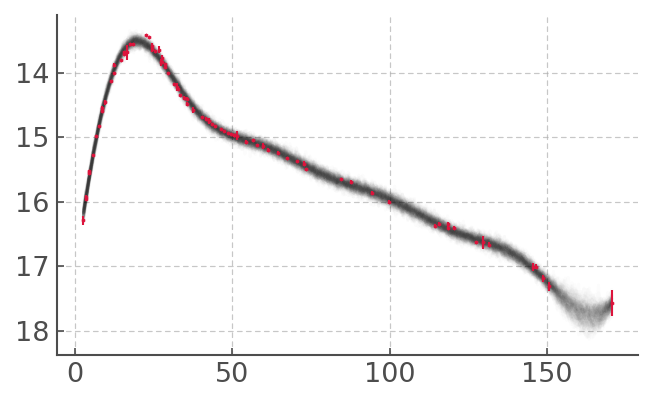

In [21]:
# Finally we can plot them all alongside the data 
for i in range(test.shape[0]):
    _v_i = test[i,:]
    plt.plot(x_interp[:,0], _v_i, alpha=0.01, c='k')
    
plt.errorbar(t_norm, data.V, yerr=data.Verr, marker='h', color='crimson', alpha=1, 
             ls=' ', lw=1, markersize=2, zorder=1000)
plt.gca().invert_yaxis()


This is essentially a manual version of the plot we get automatically from GPy - we need those methods to get the sampled LC we need to calculate the four LC parameters, as well as to make the plots for the figures shown in the paper. 

### 3.2 Calculate the four lightcurve parameters

The function below calculates:
* t_max (which is t rise since our time series was scaled with the explosion date). 
* $\Delta$ mag$_{30-40}$ 
* dm1
* dm2

In [45]:
def sampled_LC_params(t, V, alpha=0.01):
    _mag_interp=V
    _time_interp = t

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]
    ax1.plot(_time_interp, _mag_interp, c='k', label='GP', alpha=alpha)
    
    x_30_40 = np.atleast_2d(np.array([30, 40])).T
    mag_30_40, __ = m.predict(x_30_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_30_40[1]-mag_30_40[0])
    ax1.axvline(_time_interp[_ind_tmax],c='k', label='t_max', alpha=alpha)
    ax1.axvline(x_30_40[0],c='k', ls=':', alpha=alpha)
    ax1.axvline(x_30_40[1],c='k', ls=':', alpha=alpha)

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) # important to not cut V_interp otherwise fucked

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':',label='t_dm1', alpha=alpha)

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--', label='t_dm2', alpha=alpha)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]


Let's see what the ensemble of the samples and corresponding parameters look like together:

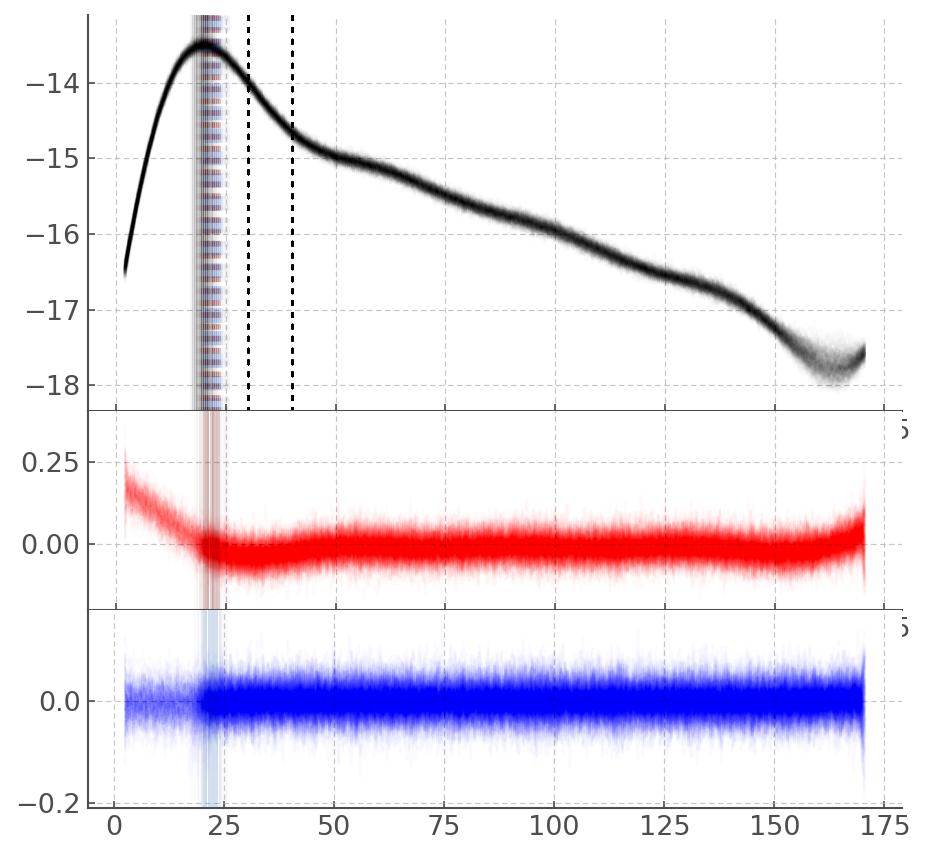

In [46]:
m=m_rbf
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])


list_params = []

t = np.atleast_2d(np.arange(int(t_norm.min()), int(t_norm.max())+1,0.5)).T

_mag_interp, sigma = m.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

test = np.random.multivariate_normal(_mag_interp,  sigma, size=200)
ls_tmax = []
ls_dm4030 = []
for i in range(test.shape[0]):
    _v_i = test[i,:]
    _params = sampled_LC_params(t=t[:,0], V=_v_i, alpha=0.01)
    list_params.append(list(_params))
    ls_tmax.append(_params[0])
    ls_dm4030.append(_params[-1])

As we can see there is a variation of several days in the calculation of the parameters when we calculate them from individualy sampled LC and then plot it all together. To get something that looks like the Pessi results for the dm1 and dm2 parameters we need to calculate the parameters from the derivates of the mean LC model. 


Let's now calculate the parameters using the mean LC model 

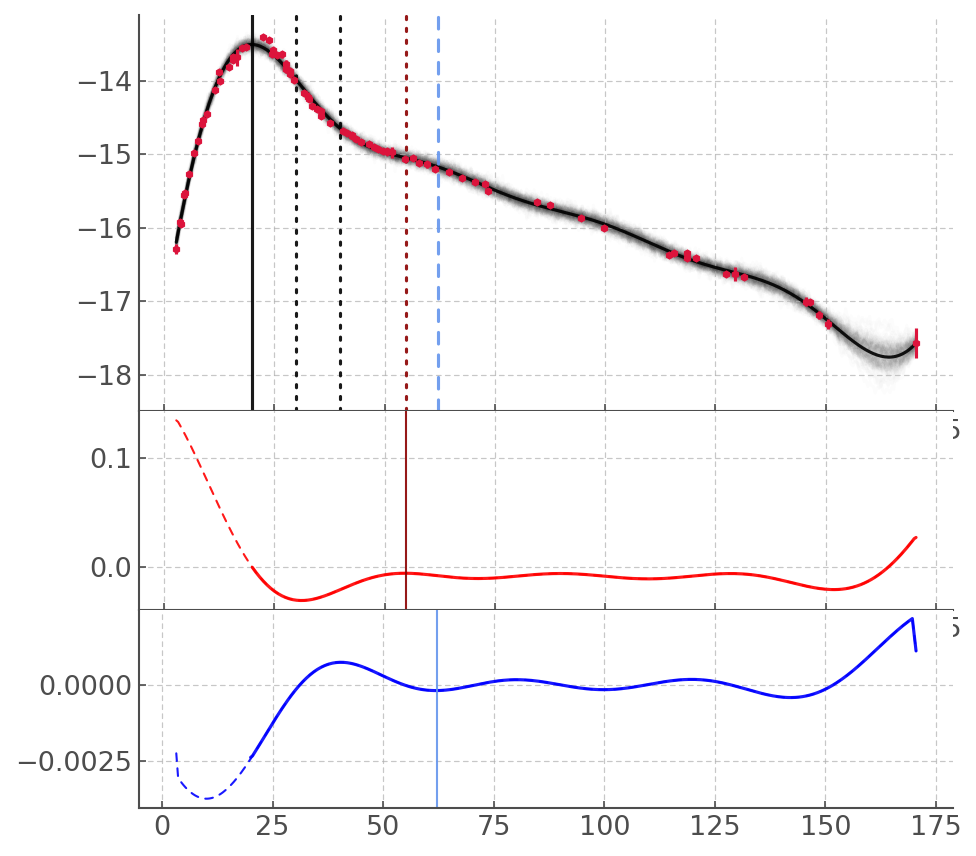

In [49]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = m_rbf.predict(t, full_cov=True)
_mag_interp=_mag_interp[:,0]*-1

_params = sampled_LC_params(t=t[:,0], V=_mag_interp, alpha=0.9)
    
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V*-1, yerr = data.Verr, ls=' ',
             zorder=1000, color='crimson', marker='h', markersize=4)

test = np.random.multivariate_normal(_mag_interp,  sigma, size=100)
for i in range(test.shape[0]):
    _v_i = test[i,:]
    ax1.plot(t[:,0], _v_i, alpha=0.01, c='k', zorder=0.1)

Let's save our results

In [50]:
results.loc[sn].iloc[0] = data.texp.iloc[0]
results.loc[sn].iloc[1:] = _params
results.to_csv('params_best_GP_IIb.dat')

In [51]:
results

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2008ax,54528.3,20.0123,34.885,42.0301,0.664096
SN2011dh,NaN,NaN,NaN,NaN,NaN
SN1993J,NaN,NaN,NaN,NaN,NaN
SN2006T,NaN,NaN,NaN,NaN,NaN
SN2004ex,NaN,NaN,NaN,NaN,NaN
SN2008aq,NaN,NaN,NaN,NaN,NaN
SN2013df,NaN,NaN,NaN,NaN,NaN
SN2006el,NaN,NaN,NaN,NaN,NaN


### 3.3 Save the model!

We don't want to be re-optimizing a model every time we want a plot, we can simply save our model object and then load it later on so we can perform interpolations at will! For SN 2008ax I am saving the `m_rbf` model. It is marginally better at fitting the data (see paper) and although the model with the white noise and bias kernel work just as well, I prefer opting for the simplest good model. 

In [52]:
_file = open('SN2008ax.gpym', 'wb')
pickle.dump(m, _file)
_file.close()

## 4. Fit with sklearn

Let's now use a different GP library to perform our fits. You'll see I'm changing the `sample_LC_params` function and adding code to allow either the `sklearn` or `GPy` implementation to be handled. They have very subtely different ways of returning interpolated/fitted data and we need to standardise `_mag_interp` before it hits the rest of the code so that everything goes according to plan. 

I'm also setting up the **plotting** into function just to save up on space. Not the most modular but this code only has one job so it'll do! The output of this function is the final plot of this notebook and this code is the basis for the code that created the final plots we see in the paper. 

In [60]:
def sampled_LC_params(m, t, alpha=0.01, ax1 = None, ax2 = None, ax3 = None, size=100):
    
    try:
        _mag_interp, sigma = m.predict(t, full_cov=True) # GPy implementation
        _mag_interp=_mag_interp[:,0]*-1
    except TypeError:
        _mag_interp, sigma = m.predict(t, return_cov=True) # sklearn implementation
        _mag_interp=_mag_interp*-1
    
    _time_interp = t[:,0]

    _ind_tmax=_mag_interp.argmax()
    t_max = _time_interp[_ind_tmax]

    ax1.plot(_time_interp, _mag_interp*-1, c='k', label='GP', alpha=alpha, zorder=10000)
    
    
    x_30 = np.atleast_2d(np.array([30])).T
    x_40 = np.atleast_2d(np.array([40])).T

    mag_30 =  m.predict(x_30)
    mag_40 =  m.predict(x_40)

    # DELTA MAG 40 30
    dm_40_30 = (mag_40-mag_30)
    ax1.axvline(_time_interp[_ind_tmax],c='grey', lw=1, alpha=alpha, label='t$_{max}$')
    ax1.axvline(x_30,c='k', ls=':', alpha=0.5, label='+30 days')
    ax1.axvline(x_40,c='k', ls=':', alpha=0.8, label='+40 days')

    ### FIRST DERIVATIVE 
    grad1 = np.gradient(_mag_interp)[_ind_tmax:] # after max
    ax2.plot(_time_interp, np.gradient(_mag_interp),lw=1, color='r', ls='--', alpha=alpha)
    ax2.plot(_time_interp[_ind_tmax:], grad1, color='r', alpha=alpha)

    # need second derivative to get the maximum
    grad2 = np.gradient(grad1) 

    # this finds the locations where grad2 goes from positive to negative - indicating peaks in grad1
    argmax_grad1 = [False] + [True if grad2[i]<0 and grad2[i-1]>0  else False for i in np.arange(1,grad2.shape[0])]
    t_dm1 = _time_interp[_ind_tmax:][argmax_grad1][0]

    # plotting location of t_dm1
    ax2.axvline(t_dm1, c='darkred', lw=1, alpha=alpha)
    ax1.axvline(t_dm1, c='darkred',  ls=':', alpha=alpha, label='dm1')

    ### SECOND DERIVATIVE 
    ax3.plot(_time_interp[1:], np.gradient(np.gradient(_mag_interp))[1:],lw=1,  
             color='b', ls='--', alpha=alpha)
    ax3.plot(_time_interp[_ind_tmax:], grad2, color='b', alpha=alpha)
    grad3 = np.gradient(grad2)
    argmin_grad2 = [False] + [True if grad3[i]>0 and grad3[i-1]<0  else False for i in np.arange(1,grad3.shape[0])]
    t_dm2 = _time_interp[_ind_tmax:][argmin_grad2][0]
    ax3.axvline(t_dm2, c='cornflowerblue', lw=1, alpha=alpha)
    ax1.axvline(t_dm2, c='cornflowerblue', ls='--',  alpha=alpha, label='dm2')
    
    ## Sampling to show uncertianties
    test = np.random.multivariate_normal(_mag_interp,  sigma, size=size)
    for i in range(test.shape[0]):
        _v_i = test[i,:]
        ax1.plot(_time_interp , _v_i*-1, alpha=0.01, zorder=0.1, color='k')
        _grad1 = np.gradient(_v_i)
        ax2.plot(_time_interp, _grad1, color='r', alpha=0.01)
        _grad2 = np.gradient(_grad1)
        ax3.plot(_time_interp, _grad2, color='b', alpha=0.01)
    
    return t_max, t_dm1-t_max, t_dm2-t_max, dm_40_30[0]

In [54]:
t_norm = data.MJD.values - data.texp.iloc[0]
t_exp = 0

# NOTE THE y and X are slightly different shapes of arrays compared to GPy
y=data.V.values
X=np.atleast_2d(t_norm).T

err = data.Verr.values

# Now we set up kernels mentioned in the paper
k_rbf = sklgp.kernels.RBF(length_scale_bounds=(1,200)) 
k_matern = sklgp.kernels.Matern(length_scale_bounds=(1,1000), nu=1.5) 
k_white = sklgp.kernels.WhiteKernel(0.1)
k_rq = sklgp.kernels.RationalQuadratic(length_scale_bounds=(1,100), alpha=0.2) 


### 4.1 RBF and Rational Quadratic

As we'll see not all kernels are created equal. The RBF in sklearn falls over its face in a dramatic fashion

 /home/fste075/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


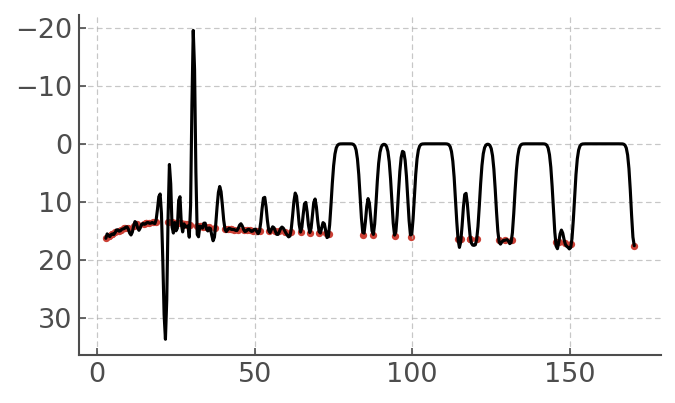

In [55]:
gp = sklgp.GaussianProcessRegressor(kernel=k_rbf, n_restarts_optimizer=100, normalize_y=False)
gp.fit(X, y)

x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T
_mag_interp, sigma = gp.predict(x, return_std=True)
_time_interp = x.T[0]

plt.plot(x, _mag_interp, c='k', label='GP')
plt.scatter(t_norm, y, label='data')
plt.gca().invert_yaxis()


### 4.2 RBF+white

let's see if adding a bit of white noise will help

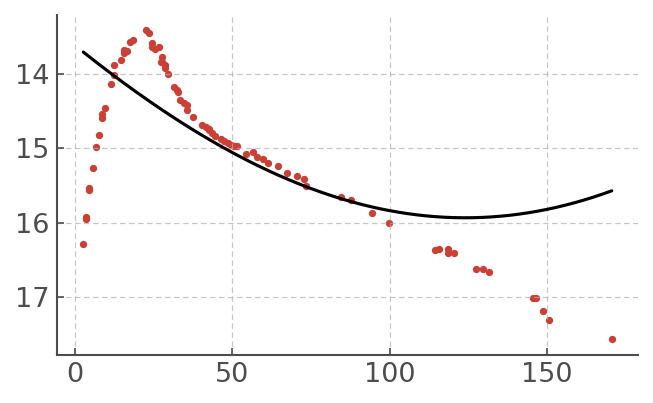

In [56]:
k_white = sklgp.kernels.WhiteKernel(0.1)

gp = sklgp.GaussianProcessRegressor(kernel=k_rbf+k_white, n_restarts_optimizer=100, normalize_y=False)
gp.fit(X, y)
x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T
_mag_interp, sigma = gp.predict(x, return_std=True)
_time_interp = x.T[0]

plt.plot(x, _mag_interp, c='k', label='GP')
plt.scatter(t_norm, y, label='data')
plt.gca().invert_yaxis()

No it does not ...

### 4.3 Matern
Let's try our Matern kernel now, as we did with GPy, maybe it'll perform better!

 /home/fste075/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


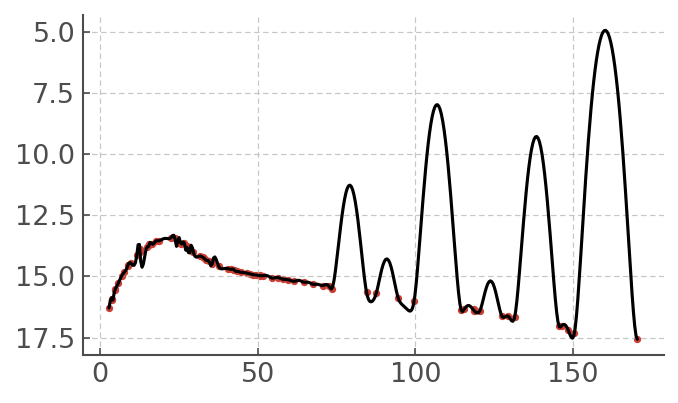

In [57]:
gp = sklgp.GaussianProcessRegressor(kernel=k_matern, n_restarts_optimizer=100, normalize_y=False)
gp.fit(X, y)

x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T
_mag_interp, sigma = gp.predict(x, return_std=True)
_time_interp = x.T[0]

plt.plot(x, _mag_interp, c='k', label='GP')
plt.scatter(t_norm, y, label='data')
plt.gca().invert_yaxis()

**It's terrible!** and this is a very good demonstration of what it means for our kernel to be stationary and to overfit the data because it *expects* large deviations on short timescales. Now obviously those large deviations we see in the plot are only one part of the solution - I've not plotted the **ucnertainties** we get from the predicted covariance in these regions of the LC, adn they would be massive! But they needen't be. We know a SN LC will not behave like that - our kernel is **misinformed**.

### 4.4 Basic Kernel engineering
The issue is that we know our SN evolves quickly early on and less quickly later on - we need a way to capture this in the fit. We can do this by adding kernels together in a clever way (kernel engineering). We know the half life of Nickel 56, which powers the the peak of the lightcurve, is about 7 days. The cobalt that dominates the latter part has a half life of about 60 days. So let's use this information as starting points.

Also we're going to use RationalQuadratic kernels - they're a mix of RBFs (and the RBFs in GPy seem to be sklearn's RationalQuadratics) and slightly better behaved. 

 /home/fste075/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
 /home/fste075/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


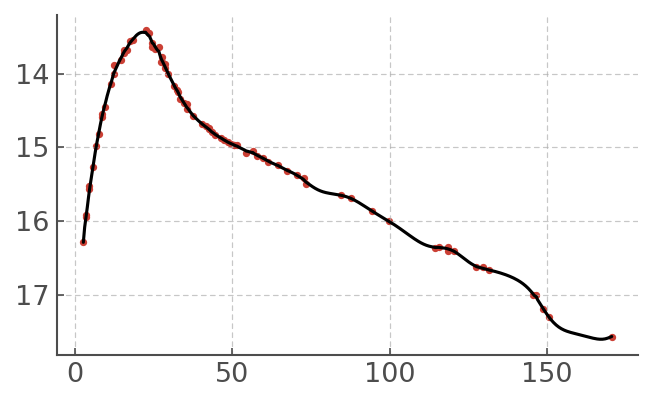

In [58]:
k_short = sklgp.kernels.RationalQuadratic(length_scale=7) 
k_long = sklgp.kernels.RationalQuadratic(length_scale=60) 

gp = sklgp.GaussianProcessRegressor(kernel=k_short + k_long, n_restarts_optimizer=100, normalize_y=False)
gp.fit(X, y)

x=np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T
_mag_interp, sigma = gp.predict(x, return_std=True)
_time_interp = x.T[0]

plt.plot(x, _mag_interp, c='k', label='GP')
plt.scatter(t_norm, y, label='data')
plt.gca().invert_yaxis()

**HUZZAH!** It's still over fitting a bit the latter part of the LC but it's not insane. And you'll notice that if you add a k_white kernel above the kit doesn't change, whereas perviously it went from squiggly to basically a smoothly decaying curve. Why is that? That's because earlier on the data kernel (RBF or MAtern) was doing such a terrible job that the optimizer just fitted the data with noise (if you plotted the uncertainties they'd cover the data). 

### 4.5 LC parameters from sklearn

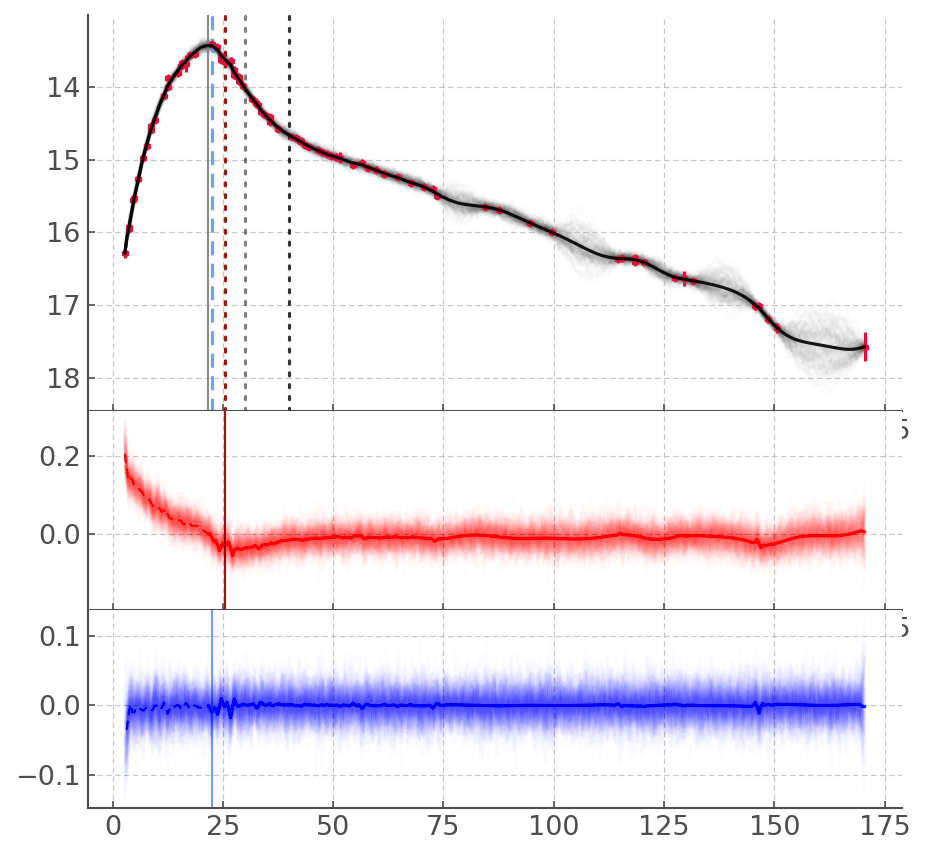

In [61]:
fig = plt.figure(figsize=(7,7))
gs = GridSpec(4, 4, hspace=0)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

t = np.atleast_2d(np.linspace(t_norm.min(), t_norm.max(),400)).T

_mag_interp, sigma = gp.predict(x, return_cov=True)
_time_interp = x.T[0]

_mag_interp=_mag_interp[:]

_params = sampled_LC_params(t=t, m=gp, alpha=0.9, ax1=ax1, ax2=ax2, ax3=ax3)
    
ax1.errorbar(data.MJD-data.texp.iloc[0], data.V, yerr = data.Verr, ls=' ',
             zorder=1000, color='crimson', marker='h', markersize=4)

ax1.invert_yaxis()

save the results!

In [62]:
results_skl.loc[sn].iloc[0] = data.texp.iloc[0]
results_skl.loc[sn].iloc[1:] = _params
results_skl.to_csv('params_best_GP_IIb_SKL.dat')

In [63]:
results_skl

,texp,trise,dm1,dm2,dm4030
event,,,,,
SN2008ax,54528.3,21.6935,3.78271,0.840602,0.641308
SN2011dh,NaN,NaN,NaN,NaN,NaN
SN1993J,NaN,NaN,NaN,NaN,NaN
SN2006T,NaN,NaN,NaN,NaN,NaN
SN2004ex,NaN,NaN,NaN,NaN,NaN
SN2008aq,NaN,NaN,NaN,NaN,NaN
SN2013df,NaN,NaN,NaN,NaN,NaN
SN2006el,NaN,NaN,NaN,NaN,NaN
